# CIFAR10 Challenge - CNN으로 학습하기

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
# (8) Learning rate decay
from torch.optim import lr_scheduler

## Hyper Parameters

In [2]:
batch_size=16
learning_rate=0.01
num_epoch=300

# 0. Pytorch GPU 환경 구축

[참고1] https://pytorch.org/get-started/locally/  
[참고2] https://lsjsj92.tistory.com/494  
[참고3] PyTorch를 활용한 강화학습/심층강화학습 실전 입문 (218p ~ 219p)

In [3]:
conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
print(torch.__version__)

1.2.0


In [5]:
torch.cuda.is_available()

True

In [6]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("cpu")

GeForce GTX 1060 6GB


In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# 사용방법: 명령어.to(device) → GPU환경, CPU환경에 맞춰서 동작

cuda


# 1. CIFAR10 train, test dataset 가져오기 (163MB)

MNIST: 11MB

In [8]:
cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태

cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 2


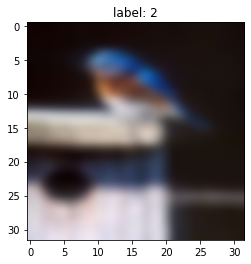

In [9]:
print("cifar_train 길이:", len(cifar_train))
print("cifar_test 길이:", len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(13)
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (3, 32, 32)

# (3, 32, 32) → (32, 32, 3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0])) # (32, 32, 3)
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

# 3. 데이터 로드 함수

In [10]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
# num_workers=2 → num_workers=0
# [출처]: https://blog.naver.com/PostView.nhn?blogId=tkdgbtkdgb&logNo=221932878301&from=search&redirect=Log&widgetTypeCall=true&topReferer=https%3A%2F%2Fsearch.naver.com%2Fsearch.naver%3Fsm%3Dtop_hty%26fbm%3D0%26ie%3Dutf8%26query%3DBrokenPipeError&directAccess=false#

batch num: [0]
한 번에 로드되는 데이터 크기: 16


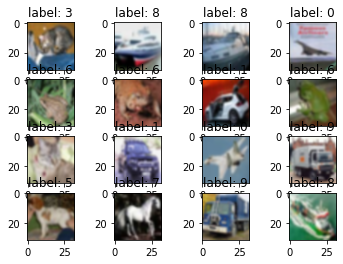

batch num: [1]
한 번에 로드되는 데이터 크기: 16


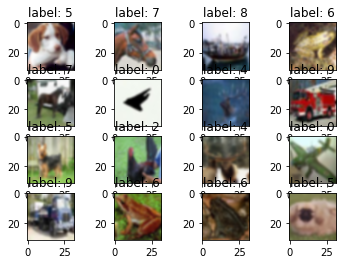

batch num: [2]
한 번에 로드되는 데이터 크기: 16


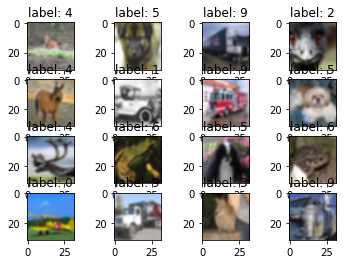

In [11]:
n = batch_size # 샘플로 그려볼 데이터 갯수(최대 batch_size 만큼)
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>=3:
        break
    
    print("batch num: [%d]" %i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy() # image 타입을 numpy로 변환 (3, 32, 32)
        
        r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
        
        img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0])) # (32, 32, 3)
        img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

        plt.subplot(4, 4, j+1) # (1, 3) 형태 plot의 j번째 자리에 그리겠다.
        plt.title("label: %d" %labels[j])
        plt.imshow(img2, interpolation='bicubic')

        
    plt.show()

# 4. 모델 선언

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            # 입력채널 수, 출력채널 수, 필터크기, 패딩
            nn.Conv2d(3, 16, 3, padding=1), # 32*32*3 → 32*32*16
            nn.LeakyReLU(),
            nn.Dropout2d(0.2), # Drop out
            nn.BatchNorm2d(16), # Batch normalization
            
            nn.Conv2d(16, 32, 3, padding=1), # 32*32*16 → 32*32*32
            nn.LeakyReLU(), # Activation function: LeakyReLU
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(2, 2), # 32*32*32 → 16*16*32
            
            nn.Conv2d(32, 64, 3, padding=1), # 16*16*32 → 16*16*64            
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(2, 2) # 16*16*64 → 8*8*64
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100), # 8*8*64 = 4096 → 100
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm1d(100), # 1줄 → BatchNorm1d
            
            nn.Linear(100, 10) # 100 → 10
        )
    
    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out=self.fc_layer(out)
        
        return out
model = CNN().to(device)

In [13]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = Variable(imgs, volatile=True).to(device) # x
        label = Variable(labels).to(device) # y

        output = imodel.forward(img) # forward prop.
        _, output_index = torch.max(output, 1)

        total += label.size(0) # batch_size씩 더함
        correct += (output_index == label).sum().float() # y_hat ↔ y
        accuracy = 100.0*correct/total
    print("Accuracy of Test Data: {}/{} ({:.5f}%)\n".format(correct, total, accuracy))

    return accuracy

# 5. Loss, Optimizer

In [14]:
loss_func = nn.CrossEntropyLoss() # 분류 → 크로스엔트로피 → logit(# of classes), target(1) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

# 6. 학습

In [15]:
print(list(model.parameters())) # 초기 파라미터 출력

[Parameter containing:
tensor([[[[ 0.1430, -0.1254,  0.0811],
          [-0.0475,  0.1125,  0.1488],
          [-0.0284, -0.0709, -0.0634]],

         [[-0.0772, -0.0722,  0.1558],
          [ 0.0782,  0.1000,  0.0006],
          [ 0.1497,  0.0815,  0.1264]],

         [[-0.0218, -0.1134,  0.1603],
          [ 0.0848, -0.1653, -0.0554],
          [ 0.0475, -0.0720, -0.0602]]],


        [[[-0.0198,  0.1623, -0.1324],
          [-0.1623, -0.1639,  0.0928],
          [ 0.0660,  0.0285, -0.0976]],

         [[-0.0614, -0.1487, -0.0467],
          [ 0.0669,  0.1593,  0.0084],
          [ 0.1905, -0.1320, -0.1835]],

         [[ 0.1187,  0.1342,  0.1364],
          [-0.1047,  0.0303, -0.1403],
          [ 0.0267,  0.0070,  0.1570]]],


        [[[-0.1073,  0.1459, -0.0587],
          [ 0.0323, -0.0339,  0.1109],
          [ 0.1341,  0.0484, -0.1801]],

         [[-0.1279, -0.0812,  0.0186],
          [-0.1500, -0.1350,  0.1871],
          [ 0.1765,  0.1570,  0.1209]],

         [[ 0.1174, -

        -0.0985,  0.0438], device='cuda:0', requires_grad=True)]


In [16]:
model.eval()
ComputeAccr(test_loader, model) # 학습전 정확도 측정

C:\Users\KIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 1000.0/10000 (10.00000%)



tensor(10., device='cuda:0')

#### learning rate decay

In [17]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
# gamma (float) – Multiplicative factor of learning rate decay. Default: 0.1.

In [18]:
model.train()

itr_arr=[] # 반복 횟수 저장 = 에폭 값 저장
loss_arr=[] # 손실함수 값 저장
accr_arr=[] # 정확도 값 저장

start = time.time() # 실행 시간 저장(1000배치 단위)
epoch_start = start # 실행 시간 저장(1에폭 단위)
start_total = start # 실행 시간 저장(전체 실행 시간)


for i in range(num_epoch): 
    print("<num_epoch: %d>" %i)
    for j, [image, label] in enumerate(train_loader): # batch_size 만큼
        x = Variable(image).to(device)
        y_ = Variable(label).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward() # back prop. - Gradient를 계산해서 각 노드에 저장
        optimizer.step() # weight 조정 - 저장된 Gradient를 이용해서 weight를 업데이트

        if j%1000==0:            
            print(j, loss)
            end = time.time()
            print("Running Time: %f s\n" %(end - start))
            start = time.time()
    
    model.eval() # 학습 진행 상황 확인용
    
    itr_arr.append(i) # 반복 횟수 저장
    loss_arr.append(loss) # 손실함수 값 저장   
    
    epoch_end = time.time()
    accr_arr.append(ComputeAccr(test_loader, model)) # 정확도 값 저장, 원래는 Validation set으로 해야함
    print("*Running Time Epoch %d: %f s\n\n" %(i, epoch_end-epoch_start))
    epoch_start = time.time()
    
    model.train() # 학습 재개
    

end_total = time.time()
print("-------------------------\n")
print("Total Running Time: %f s" %(end_total - start_total))

<num_epoch: 0>
0 tensor(2.5049, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 0.030917 s

1000 tensor(1.6558, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.622559 s

2000 tensor(1.8400, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.651511 s

3000 tensor(1.4930, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.466975 s



C:\Users\KIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 5009.0/10000 (50.09000%)

*Running Time Epoch 0: 42.458458 s


<num_epoch: 1>
0 tensor(1.6659, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.327424 s

1000 tensor(1.6910, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.598624 s

2000 tensor(1.6716, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.550751 s

3000 tensor(1.3680, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.435015 s

Accuracy of Test Data: 5771.0/10000 (57.71000%)

*Running Time Epoch 1: 42.287016 s


<num_epoch: 2>
0 tensor(1.1730, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.244568 s

1000 tensor(1.4329, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.553214 s

2000 tensor(1.3143, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.370205 s

3000 tensor(0.9424, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.569502 s

Accuracy of Test Data: 6282.0/10000 (62.82000%)

*Running Time Epoch 2: 42.247

2000 tensor(0.5339, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.569388 s

3000 tensor(0.5996, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.570149 s

Accuracy of Test Data: 7385.0/10000 (73.85000%)

*Running Time Epoch 18: 42.529808 s


<num_epoch: 19>
0 tensor(1.0315, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.264618 s

1000 tensor(0.7796, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.472241 s

2000 tensor(0.3283, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.520416 s

3000 tensor(1.3841, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.341736 s

Accuracy of Test Data: 7328.0/10000 (73.28000%)

*Running Time Epoch 19: 42.088397 s


<num_epoch: 20>
0 tensor(0.6034, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.364924 s

1000 tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.774338 s

2000 tensor(0.2623, device='cuda:0', grad_fn=<NllLossBackward>)
Running Ti

0 tensor(0.5279, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.272085 s

1000 tensor(0.3549, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.391549 s

2000 tensor(0.4137, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.760518 s

3000 tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.622643 s

Accuracy of Test Data: 7459.0/10000 (74.59000%)

*Running Time Epoch 36: 42.503839 s


<num_epoch: 37>
0 tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.293085 s

1000 tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.567561 s

2000 tensor(0.3869, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.655423 s

3000 tensor(0.6512, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.700923 s

Accuracy of Test Data: 7537.0/10000 (75.37000%)

*Running Time Epoch 37: 42.693030 s


<num_epoch: 38>
0 tensor(0.9831, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time:

3000 tensor(1.1421, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.611090 s

Accuracy of Test Data: 7485.0/10000 (74.85000%)

*Running Time Epoch 53: 42.200643 s


<num_epoch: 54>
0 tensor(0.7718, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.296816 s

1000 tensor(0.6183, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.611458 s

2000 tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.704389 s

3000 tensor(0.3189, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.693072 s

Accuracy of Test Data: 7427.0/10000 (74.27000%)

*Running Time Epoch 54: 42.747853 s


<num_epoch: 55>
0 tensor(1.8759, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.425784 s

1000 tensor(0.6188, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.441050 s

2000 tensor(1.2080, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.789453 s

3000 tensor(1.2116, device='cuda:0', grad_fn=<NllLossBackward>)
Running Ti

1000 tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.547559 s

2000 tensor(0.7801, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.581009 s

3000 tensor(0.4267, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.344990 s

Accuracy of Test Data: 7462.0/10000 (74.62000%)

*Running Time Epoch 71: 42.187737 s


<num_epoch: 72>
0 tensor(0.9770, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.178051 s

1000 tensor(0.5580, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.269320 s

2000 tensor(0.4066, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.547881 s

3000 tensor(1.2411, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.326535 s

Accuracy of Test Data: 7500.0/10000 (75.00000%)

*Running Time Epoch 72: 41.856039 s


<num_epoch: 73>
0 tensor(0.7561, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.331506 s

1000 tensor(0.5171, device='cuda:0', grad_fn=<NllLossBackward>)
Running Ti

*Running Time Epoch 88: 42.117095 s


<num_epoch: 89>
0 tensor(0.6995, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.208243 s

1000 tensor(0.6566, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.429688 s

2000 tensor(0.7289, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.714339 s

3000 tensor(0.8055, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.227834 s

Accuracy of Test Data: 7558.0/10000 (75.58000%)

*Running Time Epoch 89: 42.063779 s


<num_epoch: 90>
0 tensor(0.2860, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.330537 s

1000 tensor(0.4327, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.509832 s

2000 tensor(0.3756, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.436007 s

3000 tensor(0.6601, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.539655 s

Accuracy of Test Data: 7525.0/10000 (75.25000%)

*Running Time Epoch 90: 42.195472 s


<num_epoch: 91>
0 tensor(0.5135, dev


3000 tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.298607 s

Accuracy of Test Data: 7532.0/10000 (75.32000%)

*Running Time Epoch 106: 41.700151 s


<num_epoch: 107>
0 tensor(0.6334, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.328001 s

1000 tensor(0.8935, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.289829 s

2000 tensor(0.5581, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.037302 s

3000 tensor(1.1373, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.251563 s

Accuracy of Test Data: 7526.0/10000 (75.25999%)

*Running Time Epoch 107: 41.310089 s


<num_epoch: 108>
0 tensor(1.2051, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.444807 s

1000 tensor(0.4683, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.448134 s

2000 tensor(0.4867, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.224694 s

3000 tensor(1.1469, device='cuda:0', grad_fn=<NllLossBackward>)
Runni

1000 tensor(0.6675, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.365567 s

2000 tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.484608 s

3000 tensor(0.4624, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.144242 s

Accuracy of Test Data: 7428.0/10000 (74.28000%)

*Running Time Epoch 124: 41.602956 s


<num_epoch: 125>
0 tensor(0.9320, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.194795 s

1000 tensor(0.3410, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.420776 s

2000 tensor(0.5088, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.272364 s

3000 tensor(0.6391, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.274510 s

Accuracy of Test Data: 7507.0/10000 (75.07000%)

*Running Time Epoch 125: 41.624635 s


<num_epoch: 126>
0 tensor(0.9287, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.228152 s

1000 tensor(0.7335, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin


*Running Time Epoch 141: 42.023433 s


<num_epoch: 142>
0 tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.166548 s

1000 tensor(0.8930, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.581169 s

2000 tensor(0.2306, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.538581 s

3000 tensor(0.3934, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.440533 s

Accuracy of Test Data: 7494.0/10000 (74.93999%)

*Running Time Epoch 142: 42.272185 s


<num_epoch: 143>
0 tensor(0.5814, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.170523 s

1000 tensor(0.3204, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.374782 s

2000 tensor(0.3297, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.456105 s

3000 tensor(0.8173, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.509004 s

Accuracy of Test Data: 7451.0/10000 (74.50999%)

*Running Time Epoch 143: 42.075587 s


<num_epoch: 144>
0 tensor(0.49

2000 tensor(0.9769, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.292053 s

3000 tensor(0.3483, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.457712 s

Accuracy of Test Data: 7472.0/10000 (74.72000%)

*Running Time Epoch 159: 41.562563 s


<num_epoch: 160>
0 tensor(0.7068, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.161977 s

1000 tensor(0.2476, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.505402 s

2000 tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.400283 s

3000 tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.248621 s

Accuracy of Test Data: 7518.0/10000 (75.18000%)

*Running Time Epoch 160: 41.859428 s


<num_epoch: 161>
0 tensor(0.5775, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.168818 s

1000 tensor(0.3201, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.317699 s

2000 tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin

0 tensor(0.6185, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.185166 s

1000 tensor(0.4563, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.742738 s

2000 tensor(0.6529, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.229004 s

3000 tensor(0.5613, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.355544 s

Accuracy of Test Data: 7525.0/10000 (75.25000%)

*Running Time Epoch 177: 42.060591 s


<num_epoch: 178>
0 tensor(0.5132, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.168180 s

1000 tensor(0.4600, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.272434 s

2000 tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.584107 s

3000 tensor(0.1727, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.539228 s

Accuracy of Test Data: 7447.0/10000 (74.47000%)

*Running Time Epoch 178: 42.102392 s


<num_epoch: 179>
0 tensor(0.6731, device='cuda:0', grad_fn=<NllLossBackward>)
Running T

3000 tensor(0.9489, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.435680 s

Accuracy of Test Data: 7478.0/10000 (74.78000%)

*Running Time Epoch 194: 41.882284 s


<num_epoch: 195>
0 tensor(0.5706, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.050030 s

1000 tensor(0.8919, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.246088 s

2000 tensor(0.7356, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.128185 s

3000 tensor(0.3004, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.247625 s

Accuracy of Test Data: 7525.0/10000 (75.25000%)

*Running Time Epoch 195: 41.235945 s


<num_epoch: 196>
0 tensor(0.1637, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.058600 s

1000 tensor(0.2460, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.283648 s

2000 tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.353165 s

3000 tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin

1000 tensor(0.8346, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.395487 s

2000 tensor(0.1163, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.328662 s

3000 tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.715962 s

Accuracy of Test Data: 7509.0/10000 (75.09000%)

*Running Time Epoch 212: 42.167500 s


<num_epoch: 213>
0 tensor(0.7278, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.175917 s

1000 tensor(0.2967, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.285337 s

2000 tensor(1.3512, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.600061 s

3000 tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.570998 s

Accuracy of Test Data: 7548.0/10000 (75.48000%)

*Running Time Epoch 213: 42.133218 s


<num_epoch: 214>
0 tensor(0.4046, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.110510 s

1000 tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin


*Running Time Epoch 229: 41.437203 s


<num_epoch: 230>
0 tensor(0.5263, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.061344 s

1000 tensor(0.4222, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.561563 s

2000 tensor(0.3929, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.796494 s

3000 tensor(0.1213, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.103421 s

Accuracy of Test Data: 7447.0/10000 (74.47000%)

*Running Time Epoch 230: 42.160316 s


<num_epoch: 231>
0 tensor(0.3393, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.151613 s

1000 tensor(0.4861, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.518966 s

2000 tensor(0.1768, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.507503 s

3000 tensor(0.2548, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.543510 s

Accuracy of Test Data: 7523.0/10000 (75.23000%)

*Running Time Epoch 231: 42.263316 s


<num_epoch: 232>
0 tensor(0.51

2000 tensor(0.1655, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.496278 s

3000 tensor(0.2256, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.623617 s

Accuracy of Test Data: 7482.0/10000 (74.82000%)

*Running Time Epoch 247: 42.323119 s


<num_epoch: 248>
0 tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.284685 s

1000 tensor(0.5146, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.538201 s

2000 tensor(0.5918, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.484164 s

3000 tensor(0.9435, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.469148 s

Accuracy of Test Data: 7542.0/10000 (75.42000%)

*Running Time Epoch 248: 42.183429 s


<num_epoch: 249>
0 tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.184913 s

1000 tensor(0.1394, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.151020 s

2000 tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin

0 tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.495778 s

1000 tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.539353 s

2000 tensor(0.2078, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.549853 s

3000 tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.510983 s

Accuracy of Test Data: 7547.0/10000 (75.47000%)

*Running Time Epoch 265: 42.345534 s


<num_epoch: 266>
0 tensor(0.8966, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.786876 s

1000 tensor(0.2926, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.578105 s

2000 tensor(0.6819, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.577227 s

3000 tensor(0.5075, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.699575 s

Accuracy of Test Data: 7532.0/10000 (75.32000%)

*Running Time Epoch 266: 42.587772 s


<num_epoch: 267>
0 tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward>)
Running T

3000 tensor(0.1361, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.476486 s

Accuracy of Test Data: 7511.0/10000 (75.11000%)

*Running Time Epoch 282: 42.364014 s


<num_epoch: 283>
0 tensor(0.3184, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.319664 s

1000 tensor(0.4987, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.720858 s

2000 tensor(0.3685, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.831367 s

3000 tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.594788 s

Accuracy of Test Data: 7441.0/10000 (74.41000%)

*Running Time Epoch 283: 42.940465 s


<num_epoch: 284>
0 tensor(0.3971, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.531151 s

1000 tensor(0.3398, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.611959 s

2000 tensor(0.3639, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 13.390832 s

3000 tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)
Runnin

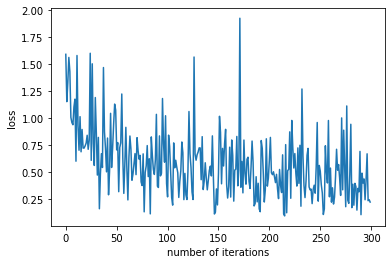

In [19]:
plt.plot(itr_arr, loss_arr) # 반복 횟수에 따른 손실함수
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.show()

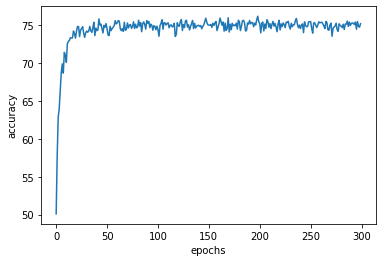

In [20]:
plt.plot(itr_arr, accr_arr) # 반복 횟수에 따른 정확도
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

# 7. 테스트

In [21]:
model.eval()
ComputeAccr(test_loader, model)

C:\Users\KIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 7518.0/10000 (75.18000%)



tensor(75.1800, device='cuda:0')

# 8. 학습된 파라미터 저장

In [22]:
print(list(model.parameters())) # 파라미터 출력

[Parameter containing:
tensor([[[[ 3.3946e+00, -2.4607e+00, -2.6721e+00],
          [-5.4129e-01,  2.5306e+01,  5.7719e+00],
          [ 7.6843e+00, -5.2182e+00,  3.9272e+00]],

         [[-4.8924e+00, -2.5248e+00, -4.2762e-01],
          [-1.8915e+01,  1.2116e+01, -4.0905e+00],
          [-7.4036e+00, -1.5786e+01, -8.5959e+00]],

         [[-1.0386e-02,  5.9921e+00, -6.3236e-01],
          [-1.1307e+01,  2.5498e+01,  1.0125e+00],
          [ 6.4233e+00,  4.8061e-02,  3.3902e+00]]],


        [[[-1.0415e+00,  8.1615e+00,  4.3895e+00],
          [ 2.8712e-01, -1.2520e+01,  1.4944e+01],
          [-6.9913e+00,  5.1895e-01,  9.5717e+00]],

         [[-4.7608e-01, -2.0116e+00, -2.0078e+00],
          [ 7.0015e+00, -2.4426e+01,  4.2244e+00],
          [-5.7409e+00, -1.7897e+01, -1.2098e+01]],

         [[-1.7787e+00,  4.7019e+00, -2.4772e+00],
          [ 3.6180e+00, -1.7451e+01,  5.9590e-01],
          [ 8.3593e+00,  3.5513e+00,  2.9314e+00]]],


        [[[-6.8231e+00, -6.0107e+00,  8.516

        -1.7884, -1.6087], device='cuda:0', requires_grad=True)]


In [23]:
netname = './nets/mlp_weight.pkl'
torch.save(model, netname, ) # 학습된 모델을 pkl파일로 저장

C:\Users\KIMA\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 9. 학습된 파라미터 불러오기

In [24]:
netname = './nets/mlp_weight.pkl'
# netname = './mlp_weight_002.pkl'
model = torch.load(netname) # pkl파일로 학습된 모델을 불러오기

In [25]:
print(list(model.parameters())) # 파라미터 출력

[Parameter containing:
tensor([[[[ 3.3946e+00, -2.4607e+00, -2.6721e+00],
          [-5.4129e-01,  2.5306e+01,  5.7719e+00],
          [ 7.6843e+00, -5.2182e+00,  3.9272e+00]],

         [[-4.8924e+00, -2.5248e+00, -4.2762e-01],
          [-1.8915e+01,  1.2116e+01, -4.0905e+00],
          [-7.4036e+00, -1.5786e+01, -8.5959e+00]],

         [[-1.0386e-02,  5.9921e+00, -6.3236e-01],
          [-1.1307e+01,  2.5498e+01,  1.0125e+00],
          [ 6.4233e+00,  4.8061e-02,  3.3902e+00]]],


        [[[-1.0415e+00,  8.1615e+00,  4.3895e+00],
          [ 2.8712e-01, -1.2520e+01,  1.4944e+01],
          [-6.9913e+00,  5.1895e-01,  9.5717e+00]],

         [[-4.7608e-01, -2.0116e+00, -2.0078e+00],
          [ 7.0015e+00, -2.4426e+01,  4.2244e+00],
          [-5.7409e+00, -1.7897e+01, -1.2098e+01]],

         [[-1.7787e+00,  4.7019e+00, -2.4772e+00],
          [ 3.6180e+00, -1.7451e+01,  5.9590e-01],
          [ 8.3593e+00,  3.5513e+00,  2.9314e+00]]],


        [[[-6.8231e+00, -6.0107e+00,  8.516

        -1.7884, -1.6087], device='cuda:0', requires_grad=True)]


In [26]:
model.eval()
ComputeAccr(test_loader, model)

C:\Users\KIMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 7518.0/10000 (75.18000%)



tensor(75.1800, device='cuda:0')